In [2]:
#Prerequisite imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime as dt

warnings.filterwarnings('ignore')

In [3]:
#Load the data
df1 = pd.read_csv('data\coin_gecko_2022-03-16.csv')
df2 = pd.read_csv('data\coin_gecko_2022-03-17.csv')
df = pd.concat([df1,df2],ignore_index=True)
df.head(2)

,coin,symbol,price,1h,24h,7d,24h_volume,mkt_cap,date
0,Bitcoin,BTC,40859.46,0.022,0.030,0.055,3.539076e+10,7.709915e+11,2022-03-16
1,Ethereum,ETH,2744.41,0.024,0.034,0.065,1.974870e+10,3.271044e+11,2022-03-16


In [4]:
#Data preprocessing

#Null value handling
df_cleaned = df.dropna()

#Convert columns
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'],format='%Y-%m-%d')

#check duplicate
df_cleaned.duplicated().sum()

#Define numerical & categorical features
columns = [col for col in df_cleaned.columns if col!='symbol']
num_features =  [col for col in columns if df_cleaned[col].dtype!='O']
cat_features =  [col for col in columns if df_cleaned[col].dtype=='O']
                 
print(f"Numerical features {num_features}")
print(f"Categorical features {cat_features}")

Numerical features ['price', '1h', '24h', '7d', '24h_volume', 'mkt_cap', 'date']
Categorical features ['coin']


In [5]:
#feature selection

#Create new features
df_cleaned['moving_averages'] = df_cleaned['price'].rolling(window=7).mean()
df_cleaned['volatility'] = (df_cleaned['24h'] - df_cleaned['1h']).abs()
df_cleaned['liquidity_ratio'] = df_cleaned['24h_volume'] / df_cleaned['mkt_cap']
df_cleaned = df_cleaned.dropna()


#drop less relevant features
df_cleaned = df_cleaned.drop(['coin', 'date','symbol'], axis=1)


In [6]:
#VIF analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["Feature"] = df_cleaned.columns
vif['VIF'] = [variance_inflation_factor(df_cleaned.values,i) for i in range(len(df_cleaned.columns))]

vif

,Feature,VIF
0,price,1.256500
1,1h,1.517170
2,24h,3.268147
3,7d,1.570604
4,24h_volume,1.529558
5,mkt_cap,1.588874
6,moving_averages,1.269748
7,volatility,2.680702
8,liquidity_ratio,1.313291


In [7]:
#Train test split

from sklearn.model_selection import train_test_split
X = df_cleaned.drop(['liquidity_ratio'], axis=1)
y = df_cleaned['liquidity_ratio']
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2,random_state=20)

In [8]:
#Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [9]:
#model selction
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from xgboost import XGBRegressor

models = {
    "Random Forest": RandomForestRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Linear Regression": LinearRegression(),
    "K-Neighbors": KNeighborsRegressor(),
    "Ada Boost":AdaBoostRegressor(),
    "XGB": XGBRegressor(),
    "SVM" : SVR()
}

score = {}
mae = {}
mse = {}

for model_name, model in models.items():
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    score[model_name] = r2_score(y_test,y_pred)
    mae[model_name] = mean_absolute_error(y_test,y_pred)
    mse[model_name] = mean_squared_error(y_test,y_pred)

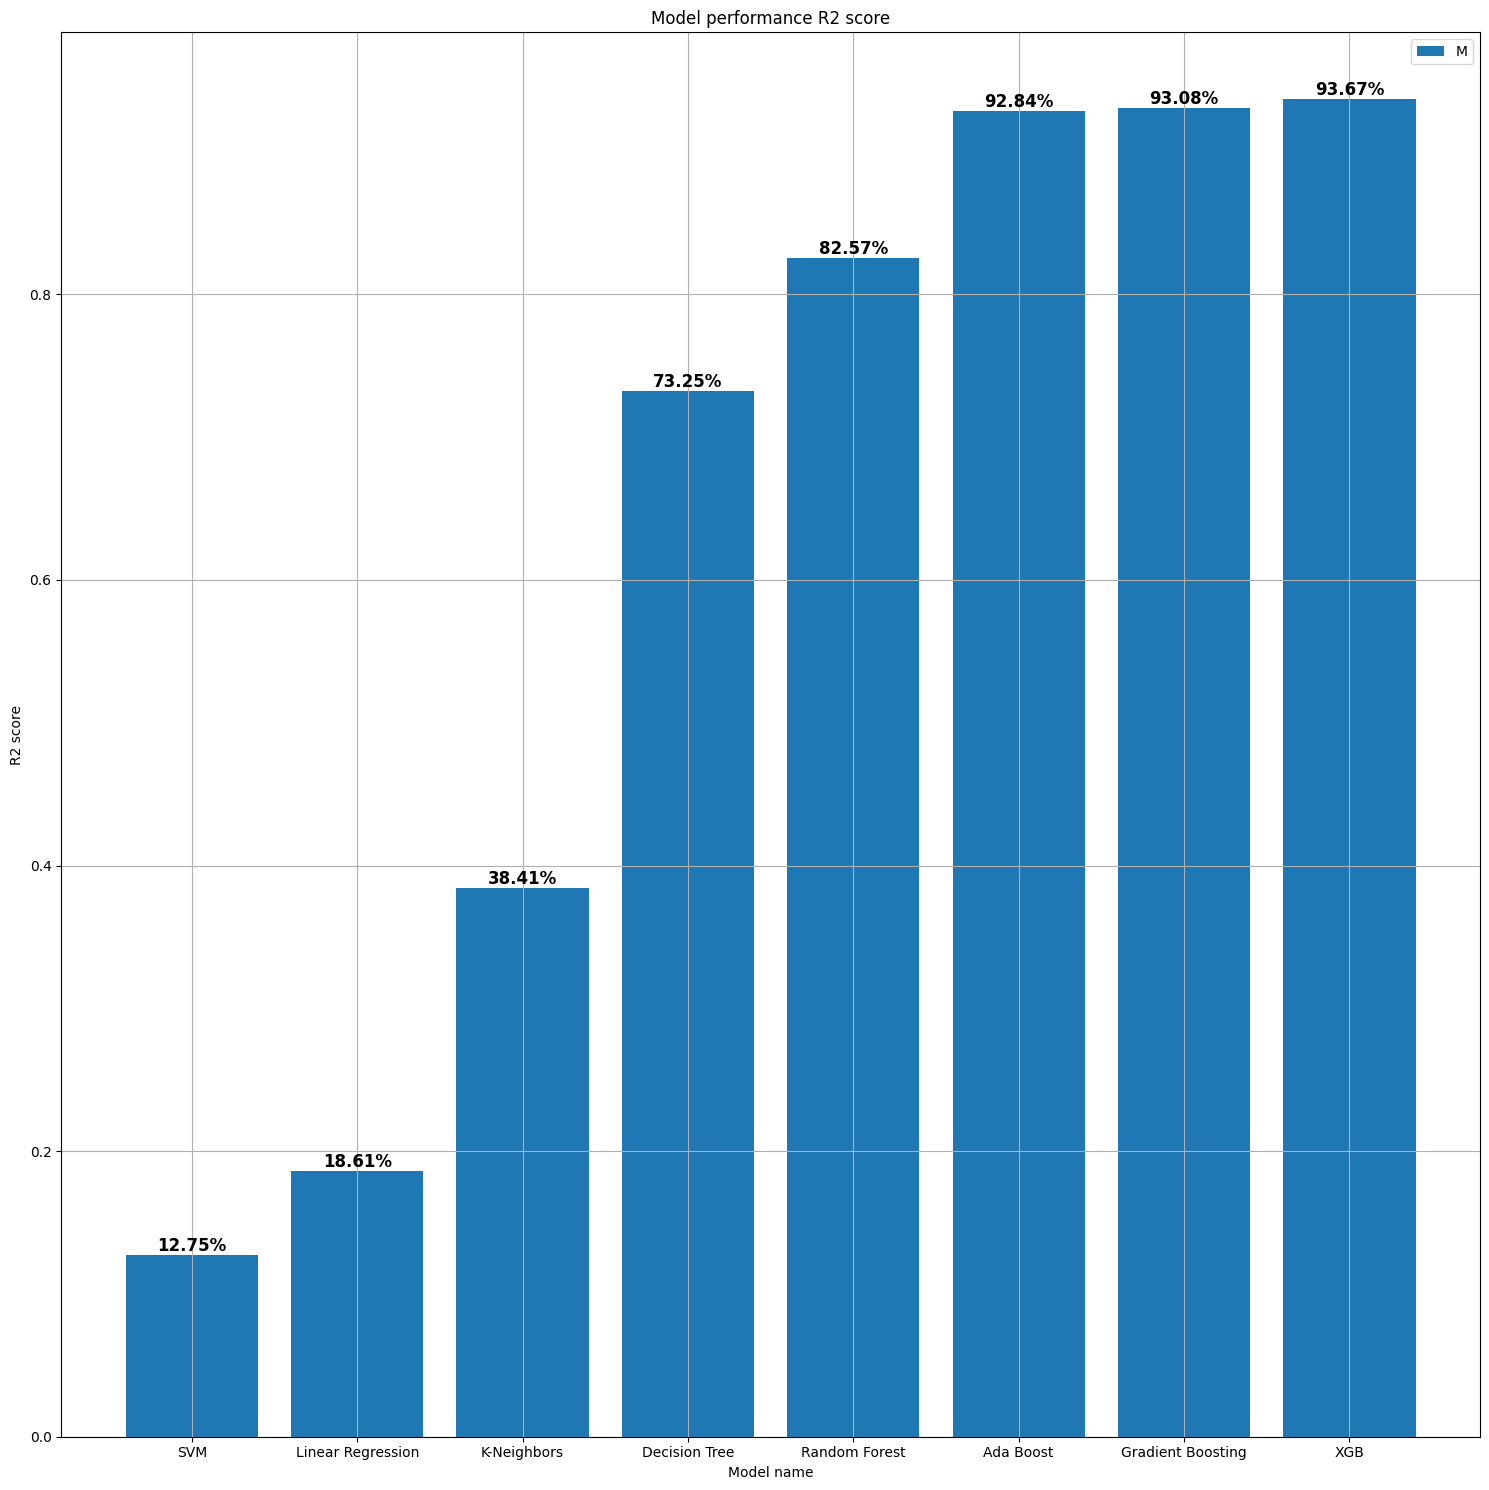

In [10]:
#Visualize
sorted_score = dict(sorted(score.items(),key= lambda item :item[1]))
plt.figure(figsize=(15,15))
bars = plt.bar(sorted_score.keys(),sorted_score.values())
plt.title("Model performance R2 score")
plt.legend('Model performance')
plt.xlabel('Model name')
plt.ylabel('R2 score')
plt.tight_layout()
plt.grid(True)

for bar in bars:
    y_val = bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2,y_val,f"{y_val:.2%}",ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

In [12]:
#Final model hyper parameter tuning
from sklearn.model_selection import GridSearchCV
# param_grid = {
#     'loss': ['squared_error'],
#     'learning_rate': [0.1],
#     'n_estimators': [100],
#     'subsample': [1.0],
#     'criterion': ['friedman_mse'],
#     'min_samples_split': [2],
#     'min_samples_leaf': [1],
#     'min_weight_fraction_leaf': [0.0],
#     'max_depth': [3],
#     'min_impurity_decrease': [0.0],
#     'max_features': [None],
#     'alpha': [0.9],
#     'warm_start': [False],
#     'validation_fraction': [0.1],
#     'n_iter_no_change': [None],
#     'tol': [0.0001],
#     'ccp_alpha': [0.0]
# }
param_grid = {
    'n_estimators': [300, 500], 
    'learning_rate': [0.05, 0.1, 0.2],  
    'max_depth': [3, 6, 9],  
    'subsample': [0.8, 1.0], 
    'colsample_bytree': [0.8, 1.0],  
    'gamma': [0, 0.1],  
    'reg_alpha': [0.01, 0.1],  
    'reg_lambda': [0.01, 0.1],  
}
cv = GridSearchCV(cv=5,verbose=8,param_grid=param_grid,estimator= XGBRegressor(),scoring='r2')
cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",cv.best_params_)
print("accuracy :",cv.best_score_)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV 1/5] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=300, reg_alpha=0.01, reg_lambda=0.01, subsample=0.8;, score=0.721 total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=300, reg_alpha=0.01, reg_lambda=0.01, subsample=0.8;, score=-0.504 total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=300, reg_alpha=0.01, reg_lambda=0.01, subsample=0.8;, score=0.712 total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=300, reg_alpha=0.01, reg_lambda=0.01, subsample=0.8;, score=0.343 total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=300, reg_alpha=0.01, reg_lambda=0.01, subsample=0.8;, score=0.649 total time=   0.0s
[CV 1/5] END colsample_bytree=0.8, gamma=0, learning_rate=0.

In [14]:
#Test & validation
final_model = XGBRegressor(
    colsample_bytree=0.8, 
    gamma=0, 
    learning_rate=0.2, 
    max_depth=3, 
    n_estimators=500, 
    reg_alpha=0.1, 
    reg_lambda=0.1, 
    subsample=1.0
)

final_model.fit(X_train,y_train)
ypred = final_model.predict(X_test)
print(f"R2 score : {r2_score(y_test,ypred)}")
print(f"MAE {mean_absolute_error(y_test,y_pred)}")
print(f"RMSE {np.sqrt(mean_squared_error(y_test,y_pred))}")


R2 score : 0.8599947756598849
MAE 0.12031897445625964
RMSE 0.36330355405346687


In [17]:
#Save to pikl file

import joblib
joblib.dump(final_model, '../deliverables/final_model.pkl')
joblib.dump(scaler, '../deliverables/scaler_model.pkl')

['../deliverables/scaler_model.pkl']